# Random Forest Regression

In [1]:
# basic imports
import sys
sys.path.append('../scripts/')

import numpy as np
import matplotlib.pyplot as plt

# scikit-learn 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestRegressor

# output 
import support_tools as st

## Load data

In [2]:
data = np.genfromtxt('../DATA/SDSS-centrals-rf-data.txt')

***
## Prepare the training and validation sets

This time we are only going to use star forming galaxies, train our regression on SFR

In [3]:
sf = np.where(data[:,1] == 0)[0]
data = data[sf, :]

#### Identify the target (sSFR) and the input features ($M_{\rm BH}$, $M_{\rm halo}$, $M_\ast$)

In [4]:
target = data[:,0] + data[:,-1] # SFR
features = data[:,2:]

In [5]:
scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0),
                                    with_scaling=True,
                                    copy=True)                                                          
scaled_features = scaler.fit_transform(features)

In [6]:
features_tr, features_va, target_tr, target_va = train_test_split(scaled_features,
                                                                  target,
                                                                  test_size=0.5)    

***
## Construct a RF regressor

![RandomForestRegressor](support/rf-regressor.png)
Follow [this link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) for the scikit-learn manual <br>

In [7]:
reg = RandomForestRegressor(n_estimators=200,       
                             min_samples_leaf=120,     
                             n_jobs=-1)             

***
## Train the Random Forest
using the `RandomForestRegressor` method `fit`

In [8]:
reg.fit(features_tr, target_tr)  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=120, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

***
## Evaluate RF performance and infer feature importances
We can check the algorithm's performance by predicting sSFR values for both the training and validation sets with the `predict` method

In [9]:
pred_tr = reg.predict(features_tr)    # an array of sSFR predictions for each object in the 
                                      # training sample 

pred_va = reg.predict(features_va)   # an array of sSFR predictions for each object in the 
                                     # validation sample 

Now we can plot the predicted SFR against the true SFR to see how well the algorithm performed for both the training and the validation sets

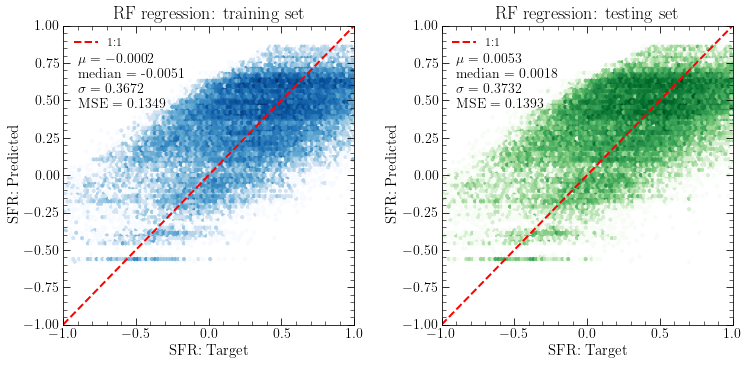

In [10]:
st.configure_plots()

fig, ax = plt.subplots(1, 2, figsize = (12, 5.5), 
                       sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.3)

# training

ax[0].hexbin(target_tr, pred_tr, cmap=plt.cm.Blues, bins='log',
             extent=[-1,1,-1,1], gridsize=100, mincnt=1)
ax[0].plot([-1,1], [-1,1], color='r', ls='--', linewidth=2., label='1:1')
ax[0].set_xlabel('SFR: Target')
ax[0].set_ylabel('SFR: Predicted' )
ax[0].set_title('RF regression: training set')
ax[0].legend()
ax[0].text(-0.9, 0.75, r'$\mu = %.4f$' 
           %np.mean(pred_tr - target_tr))    # mean difference
ax[0].text(-0.9, 0.65, 'median = %.4f' 
           %np.median(pred_tr - target_tr))    # median difference 
ax[0].text(-0.9, 0.55, r'$\sigma = %.4f$' 
           %np.std(pred_tr - target_tr))    # standard deviation
ax[0].text(-0.9, 0.45, 'MSE = %.4f' 
           %np.mean(np.power(pred_tr - target_tr, 2))) # mean squared errror


# validation
ax[1].hexbin(target_va, pred_va, cmap=plt.cm.Greens, bins='log',
             extent=[-1,1,-1,1], gridsize=100, mincnt=1)
ax[1].plot([-1,1], [-1,1], color='r', ls='--', linewidth=2., label='1:1')
ax[1].set_xlabel('SFR: Target')
ax[1].set_ylabel('SFR: Predicted')
ax[1].set_title('RF regression: testing set')
ax[1].legend()
ax[1].text(-0.9, 0.75, r'$\mu = %.4f$' 
           %np.mean(pred_va - target_va))    # mean difference
ax[1].text(-0.9, 0.65, 'median = %.4f' 
           %np.median(pred_va - target_va))    # median difference 
ax[1].text(-0.9, 0.55, r'$\sigma = %.4f$' 
           %np.std(pred_va - target_va))    # standard deviation
ax[1].text(-0.9, 0.45, 'MSE = %.4f' 
           %np.mean(np.power(pred_va - target_va, 2))) # mean squared errror


ax[1].set_xlim(-1,1)
ax[1].set_ylim(-1,1)
ax[1].tick_params(labelleft=True)

The regression tree given these hyperparameters is doing a great job at not being biased. However, the $\sigma \approx 0.4$ is not very enticing as far as SFR estimators are concerned 

#### Finally, we can check which variable was most relevant for determining the SFR

Text(0, 0.5, 'Relative performance')

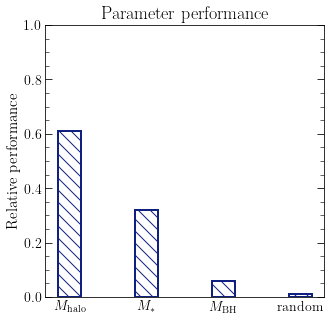

In [11]:
performance = reg.feature_importances_

varnames = np.array([
    'random', r'$M_{\rm BH}$', 
    r'$M_{\rm halo}$', r'$M_\ast$'
    ])
idx = np.argsort(performance)[::-1]

fig, ax = plt.subplots(figsize=(5,5))
loc = np.arange(features_tr.shape[1])
ax.bar(loc, performance[idx], width=0.3, 
       edgecolor='#0F2080', facecolor='w',
       hatch=2*'\\', lw=2)
ax.set_xticks(loc)
ax.tick_params(which='both', axis='x', bottom=False, top=False)
ax.set_ylim(0,1)
ax.set_xticklabels(varnames[idx])
ax.set_title('Parameter performance')
ax.set_ylabel('Relative performance')